In [1]:
# !pip install keras
# !pip install tensorflow_addons

# Importing required libraries

In [3]:
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

# Setting various constants

In [30]:
EPOCHS = 40
SAMPLE_LEN = 100
IMSIZES = (224, 240, 260, 300, 380, 456, 528, 600)
im_size = 128
SEED = 42
LR = 0.0001

# since the train.txt had 1000 entries and test.txt had 6000 entries, I took test.txt for training instead

TEST_PATH = "../input/oxford102/oxford-102-flowers/train.txt"
TRAIN_PATH = "../input/oxford102/oxford-102-flowers/test.txt"
SUB_PATH = "../input/oxford102/oxford-102-flowers/valid.txt"

sub = pd.read_csv(SUB_PATH, sep=' ', names=['image_path','category'])
test_data = sub.copy()
train_data = pd.read_csv(TRAIN_PATH, sep=' ', names=['image_path','category'])

## Taking input for training and testing and converting the data type to string so that it can be used with data generator

In [8]:
train_data["image_path"] = train_data["image_path"].astype(str)
train_data["category"] = train_data["category"].astype(str)
train_data.head()

,image_path,category
0,jpg/image_06977.jpg,34
1,jpg/image_00800.jpg,80
2,jpg/image_05038.jpg,58
3,jpg/image_06759.jpg,0
4,jpg/image_01133.jpg,45


In [9]:
train_data.dtypes

image_path    object
category      object
dtype: object

In [10]:
test_data["image_path"] = test_data["image_path"].astype(str)
test_data["category"] = test_data["category"].astype(str)
test_data.head()

,image_path,category
0,jpg/image_04467.jpg,89
1,jpg/image_07129.jpg,44
2,jpg/image_05166.jpg,4
3,jpg/image_07002.jpg,34
4,jpg/image_02007.jpg,79


In [11]:
test_data.dtypes

image_path    object
category      object
dtype: object

## Defining data generator for training and validation data

In [14]:
# applying data augmentation to the dataset by zooming, random rotation flips and brightness manipulation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   rotation_range = 360,
                                   fill_mode = 'nearest',
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   brightness_range=[0.4,1.5])

IMAGE_PATH = "../input/oxford102/oxford-102-flowers/"

# creating the dataset from the data generator
training_set = train_datagen.flow_from_dataframe(train_data,
                                                 directory = IMAGE_PATH,
                                                 x_col = "image_path",
                                                 y_col = "category",
                                                 batch_size=400,
                                                 target_size=(im_size,im_size),
                                                 shuffle=True,
                                                 color_mode='rgb',
                                                 class_mode='categorical')

# creating validation dataset with no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(test_data,
                                            directory = IMAGE_PATH,
                                            x_col = "image_path",
                                            y_col = "category",
                                            batch_size=400,
                                            target_size=(im_size,im_size),
                                            shuffle=True,
                                            color_mode='rgb',
                                            class_mode='categorical')

Found 6149 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.


In [15]:
training_set

## Defining Callbacks

In [33]:
MODEL_NAME = "InceptionV3"
i = 1

# defining the checkpoint path and log file path
chk_path = '{}_Attempt{}.h5'.format(MODEL_NAME,i)
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# defining the checkpoint for saving the model weights with highest accuracy regardless of the epochs
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

# defining early stopping of training if the validation loss doesn't change over time
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
 
# defining reducing learning rate that reduces to learning rate by a factor of 0.2 if the validation loss doesn't improve over time
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

# adding the above callbacks to a list 
callbacks = [checkpoint, reduce_lr, csv_logger]


2021-10-27 14:06:37.599152: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 14:06:37.599214: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 14:06:38.020108: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 14:06:38.020309: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## Defining Model

In [34]:
# creating a model with InceptionV3 and using transfer learning to use this model for our dataset of 102 classes
def get_model():
    # with strategy.scope():
        
        tf.random.set_seed(SEED)
        model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(im_size, im_size,3))
        final_model =  tf.keras.Sequential([
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(102, 
        kernel_initializer=keras.initializers.RandomUniform(seed=SEED),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
        ])

        final_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', 
              metrics= 'accuracy')
        
        return final_model

In [35]:
import keras
import tensorflow as tf

# steps_per_epoch = train_labels.shape[0] // BATCH_SIZE
# validation_steps = valid_labels.shape[0] // BATCH_SIZE

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size


model = get_model()
model.summary()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_top (Dense)            (None, 102)               208998    
Total params: 22,011,782
Trainable params: 21,977,350
Non-trainable params: 34,432
_________________________________________________________________


## Fitting the model to our dataset

In [36]:
history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=100,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/100
15/15 [==============================] - 70s 4s/step - loss: 0.2932 - accuracy: 0.0468 - val_loss: 0.2543 - val_accuracy: 0.0088

Epoch 00001: val_loss improved from inf to 0.25425, saving model to InceptionV3_Attempt1.h5
Epoch 2/100
15/15 [==============================] - 64s 4s/step - loss: 0.0453 - accuracy: 0.2068 - val_loss: 0.1245 - val_accuracy: 0.0100

Epoch 00002: val_loss improved from 0.25425 to 0.12453, saving model to InceptionV3_Attempt1.h5
Epoch 3/100
15/15 [==============================] - 68s 5s/step - loss: 0.0341 - accuracy: 0.3848 - val_loss: 0.0806 - val_accuracy: 0.0088

Epoch 00003: val_loss improved from 0.12453 to 0.08057, saving model to InceptionV3_Attempt1.h5
Epoch 4/100
15/15 [==============================] - 65s 4s/step - loss: 0.0256 - accuracy: 0.5368 - val_loss: 0.0753 - val_accuracy: 0.0300

Epoch 00004: val_loss improved from 0.08057 to 0.07534, saving model to InceptionV3_Attempt1.h5
Epoch 5/100
15/15 [==============================] -

## Plotting the training and test accuracy & loss over time

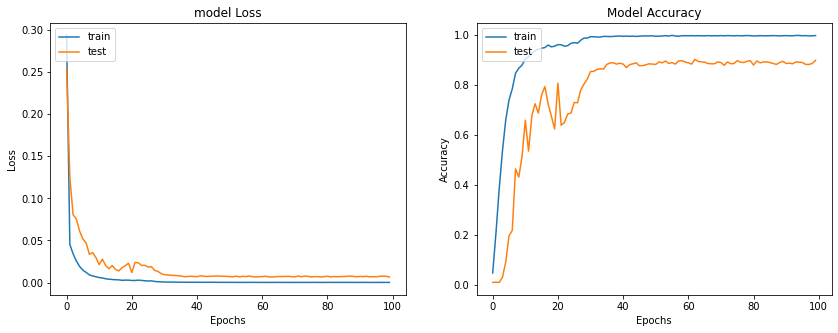

In [37]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating Model on Training and Validation set

In [38]:
train_loss, train_accu = model.evaluate(training_set)
test_loss, test_accu = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

3/3 [==============================] - 5s 2s/step - loss: 0.0072 - accuracy: 0.8892
final train accuracy = 99.84 , validation accuracy = 88.92


## Getting unseen data from test.txt file for evaluation

In [39]:
test_data = pd.read_csv(TEST_PATH, sep=' ', names=['image_path','category'])
test_data["image_path"] = test_data["image_path"].astype(str)
test_data["category"] = test_data["category"].astype(str)


IMAGE_PATH = "../input/oxford102/oxford-102-flowers/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(test_data,
                                            directory = IMAGE_PATH,
                                            x_col = "image_path",
                                            y_col = "category",
                                            batch_size=400,
                                            target_size=(im_size,im_size),
                                            shuffle=True,
                                            color_mode='rgb',
                                            class_mode='categorical')

Found 1020 validated image filenames belonging to 102 classes.


## Evaluating on test data

In [40]:
test_loss, test_accu = model.evaluate(test_set)
print("final test accuracy = {:.2f}".format(test_accu*100))

3/3 [==============================] - 5s 2s/step - loss: 0.0072 - accuracy: 0.8892
final test accuracy = 88.92
